         RAW+OHE | Acc=0.863  Prec=0.808  Rec=0.962  BestEpoch=46
      MinMax+OHE | Acc=0.990  Prec=0.981  Rec=1.000  BestEpoch=200
    Standard+OHE | Acc=1.000  Prec=1.000  Rec=1.000  BestEpoch=200
     RAW(no OHE) | Acc=0.859  Prec=0.817  Rec=0.933  BestEpoch=194
  MinMax(no OHE) | Acc=0.951  Prec=0.944  Rec=0.962  BestEpoch=200
Standard(no OHE) | Acc=1.000  Prec=1.000  Rec=1.000  BestEpoch=200

=== Summary (LR=1e-3) ===
   Preprocessing    LR  Test_Loss  Test_Accuracy  Precision   Recall  BestEpoch(val_loss)
Standard(no OHE) 0.001   0.007786       1.000000   1.000000 1.000000                  200
    Standard+OHE 0.001   0.001630       1.000000   1.000000 1.000000                  200
      MinMax+OHE 0.001   0.023714       0.990244   0.981308 1.000000                  200
  MinMax(no OHE) 0.001   0.130587       0.951219   0.943925 0.961905                  200
         RAW+OHE 0.001   0.310643       0.863415   0.808000 0.961905                   46
     RAW(no OHE) 0.001   0.34942

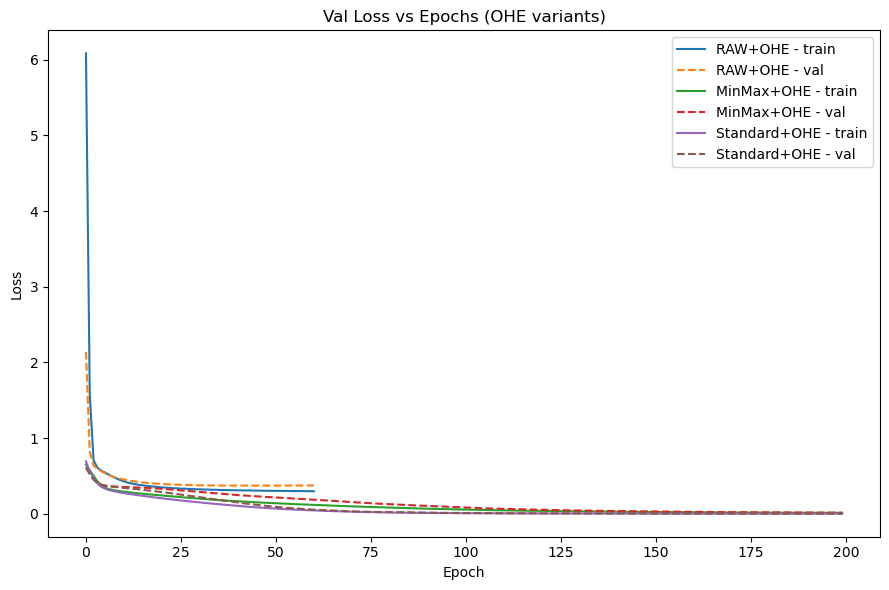

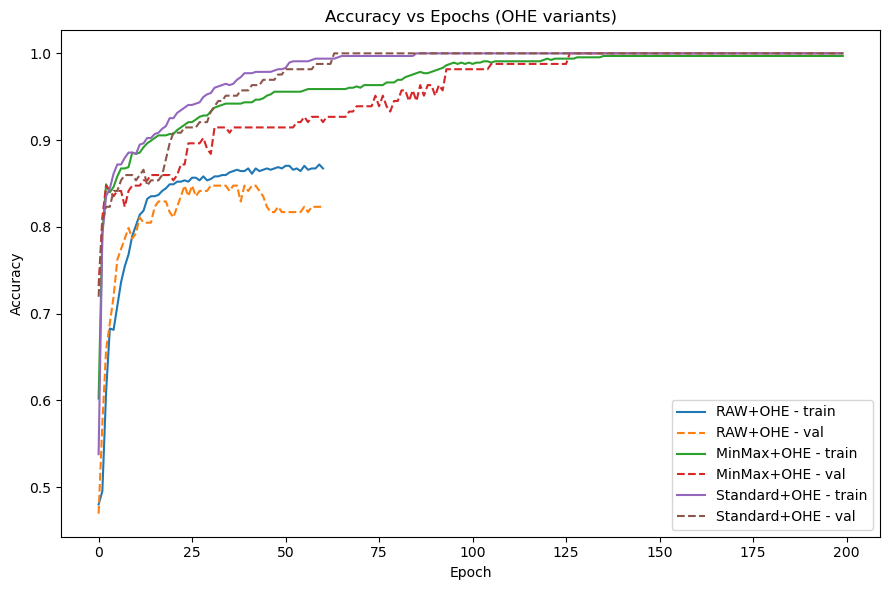

In [1]:

# Heart Disease NN Experiments

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, MinMaxScaler, OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)


csv_path = Path("heart.csv")
if not csv_path.exists():
    raise FileNotFoundError("heart.csv not found in working directory.")

df = pd.read_csv(csv_path).replace('?', np.nan)


expected_cols = ['age','sex','cp','trestbps','chol','fbs','restecg',
                 'thalach','exang','oldpeak','slope','ca','thal','target']

if set(expected_cols).issubset(df.columns):
    df = df[expected_cols].copy()
else:
    # If columns differ slightly, try to infer target as last col named 'target' or similar
    if 'target' not in df.columns:
        raise ValueError("Could not find 'target' column. Please ensure heart.csv has a 'target' (0/1).")
    # keep as-is, but you may want to adapt numeric/categorical lists below.

# Cast numeric where possible
for col in df.columns:
    if col != 'target':
        df[col] = pd.to_numeric(df[col], errors='coerce')
df['target'] = pd.to_numeric(df['target'], errors='coerce')

# Drop rows where target is missing
df = df.dropna(subset=['target']).copy()
df['target'] = df['target'].astype(int)


# Typical split for UCI Heart dataset
numeric_features = ['age','trestbps','chol','thalach','oldpeak']
categorical_features = ['sex','cp','fbs','restecg','exang','slope','ca','thal']

# Safety check (intersect with actual columns)
numeric_features = [c for c in numeric_features if c in df.columns]
categorical_features = [c for c in categorical_features if c in df.columns]

X = df.drop(columns=['target'])
y = df['target'].values

# Train/Test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)


# Imputers
num_imputer = SimpleImputer(strategy='median')
cat_imputer = SimpleImputer(strategy='most_frequent')


raw_with_ohe = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", num_imputer)]), numeric_features),
        ("cat", Pipeline([("imp", cat_imputer), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), categorical_features)
    ],
    remainder='drop'
)


minmax_with_ohe = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", num_imputer), ("sc", MinMaxScaler())]), numeric_features),
        ("cat", Pipeline([("imp", cat_imputer), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), categorical_features)
    ],
    remainder='drop'
)

# Standard, WITH one-hot
standard_with_ohe = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", num_imputer), ("sc", StandardScaler())]), numeric_features),
        ("cat", Pipeline([("imp", cat_imputer), ("ohe", OneHotEncoder(handle_unknown="ignore"))]), categorical_features)
    ],
    remainder='drop'
)

# We impute numerics and categoricals, but do not scale or OHE.
raw_no_ohe = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", num_imputer)]), numeric_features),
        ("cat", Pipeline([("imp", cat_imputer)]), categorical_features)
    ],
    remainder='drop'
)

#  MinMax, NO one-hot (scale ONLY numerics, keep categoricals as ints)
minmax_no_ohe = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", num_imputer), ("sc", MinMaxScaler())]), numeric_features),
        ("cat", Pipeline([("imp", cat_imputer)]), categorical_features)
    ],
    remainder='drop'
)

#  Standard, NO one-hot
standard_no_ohe = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imp", num_imputer), ("sc", StandardScaler())]), numeric_features),
        ("cat", Pipeline([("imp", cat_imputer)]), categorical_features)
    ],
    remainder='drop'
)

preprocessors = {
    "RAW+OHE": raw_with_ohe,
    "MinMax+OHE": minmax_with_ohe,
    "Standard+OHE": standard_with_ohe,
    "RAW(no OHE)": raw_no_ohe,
    "MinMax(no OHE)": minmax_no_ohe,
    "Standard(no OHE)": standard_no_ohe
}


# Model builder

def build_model(input_dim, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(16, activation="relu"),
        layers.Dense(1, activation="sigmoid")   # binary classification
    ])
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
    return model


def train_and_eval(preproc_name, preproc, X_train, y_train, X_test, y_test,
                   lr=1e-3, epochs=200, batch_size=32, patience=15, verbose=0):
    # Fit transform
    Xtr = preproc.fit_transform(X_train)
    Xte = preproc.transform(X_test)

    # Convert to dense if sparse
    if hasattr(Xtr, "toarray"):
        Xtr = Xtr.toarray()
        Xte = Xte.toarray()

    # Ensure float
    Xtr = Xtr.astype(np.float32)
    Xte = Xte.astype(np.float32)

    model = build_model(Xtr.shape[1], lr=lr)

    es = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=patience, restore_best_weights=True
    )

    history = model.fit(
        Xtr, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=verbose
    )

    # Evaluate
    loss, acc = model.evaluate(Xte, y_test, verbose=0)
    # Predict & compute precision/recall
    y_prob = model.predict(Xte, verbose=0).ravel()
    y_pred = (y_prob >= 0.5).astype(int)

    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)

    # Convergence speed proxy: epoch with best val_loss
    val_losses = history.history.get("val_loss", [])
    if len(val_losses) > 0:
        best_epoch = int(np.argmin(val_losses)) + 1
    else:
        best_epoch = len(history.history.get("loss", []))

    result = {
        "Preprocessing": preproc_name,
        "LR": lr,
        "Test_Loss": loss,
        "Test_Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "BestEpoch(val_loss)": best_epoch,
        "History": history
    }
    return result


# Run main experiments

results = []
for name, pre in preprocessors.items():
    res = train_and_eval(name, pre, X_train, y_train, X_test, y_test, lr=1e-3, verbose=0)
    results.append(res)
    print(f"{name:>16} | Acc={res['Test_Accuracy']:.3f}  Prec={res['Precision']:.3f}  Rec={res['Recall']:.3f}  BestEpoch={res['BestEpoch(val_loss)']}")

summary = pd.DataFrame([{k:v for k,v in r.items() if k != "History"} for r in results]).sort_values(by="Test_Accuracy", ascending=False)
print("\n=== Summary (LR=1e-3) ===")
print(summary[['Preprocessing','LR','Test_Loss','Test_Accuracy','Precision','Recall','BestEpoch(val_loss)']].to_string(index=False))


#    Compare RAW+OHE vs Standard+OHE under different LRs

lr_grid = [1e-2, 1e-3, 1e-4]
lr_results = []

for pre_name in ["RAW+OHE", "Standard+OHE"]:
    pre = preprocessors[pre_name]
    for lr in lr_grid:
        res = train_and_eval(pre_name, pre, X_train, y_train, X_test, y_test, lr=lr, verbose=0)
        lr_results.append(res)
        print(f"[LR sweep] {pre_name:>12} | LR={lr:.0e} | Acc={res['Test_Accuracy']:.3f} Prec={res['Precision']:.3f} Rec={res['Recall']:.3f} BestEpoch={res['BestEpoch(val_loss)']}")

lr_table = pd.DataFrame([{k:v for k,v in r.items() if k != "History"} for r in lr_results])
print("\n=== LR Sensitivity (RAW+OHE vs Standard+OHE) ===")
print(lr_table[['Preprocessing','LR','Test_Accuracy','Precision','Recall','BestEpoch(val_loss)']].sort_values(by=['Preprocessing','LR']).to_string(index=False))

#plot
def plot_histories(named_histories, metric="loss", title=None):
    plt.figure(figsize=(9,6))
    for label, hist in named_histories:
        plt.plot(hist.history[metric], label=f"{label} - train")
        if f"val_{metric}" in hist.history:
            plt.plot(hist.history[f"val_{metric}"], linestyle='--', label=f"{label} - val")
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(title or f"Training {metric.capitalize()} Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Pick representative three to visualize: RAW+OHE, MinMax+OHE, Standard+OHE
hist_map = {r['Preprocessing']: r['History'] for r in results}
to_plot = [(name, hist_map[name]) for name in ["RAW+OHE","MinMax+OHE","Standard+OHE"] if name in hist_map]

if to_plot:
    plot_histories(to_plot, metric="loss", title="Val Loss vs Epochs (OHE variants)")
    plot_histories(to_plot, metric="accuracy", title="Accuracy vs Epochs (OHE variants)")
